# How to Perform Approximate Nearest Neighbor Search in PECOS

## Introduction
Recall that PECOS is a scalable ML library for predictions on enormous and correlated output space. Therefore, we also support inference of embedding-based models such as dual-encoders, which is often formulated as a Maximum Inner Product Search (**MIPS**) or equivalently, an approximate nearest neighbor (**ANN**) search problem.

In PECOS, we implemented a state-of-the-art graph-based ANN search algorithm, namely **H**ierarchical **N**avigable **S**mall **W**orld (**HNSW**) model. The life-cycle of HNSW can be divided into twp steps:
* *Training*: given user-provided database vectors, build the HNSW graph data structures for indexing;
* *Prediction*: given any query vector, return the top-K approximate nearest vectors indexed in the database.

More specifically, the **search (i.e., inference)** procedure of HNSW can be summarized as:
* For each layer, conduct best first search traversal. The best candidate serves as an initial point to next layer;
* Traverse from top layer (course-grain graph, long-range link) to bottom layer (fine-grain graph, short-range link);
* The bottom layer graph contains all database items as the nodes.
<div> <br/><img src="imgs/pecos-kdd22-tutorial-hnsw-example.png" width="70%"/> </div>

## Highlight of PECOS-HNSW
In this part of tutorial, we introduce the usage of PECOS-HNSW to tackle ANN search problem, and highlight some key functionalities and features in PECOS-HNSW:

* support inference on both sparse and dense input features;
* support SIMD instructions (AVX, AVX256, and AVX512) and select the best available one in runtime;
* achieve new SOTA results compared to other popular graph-based ANN libraries (e.g., NMSLIB and HNSWLIB).
<div> <br/><img src="imgs/pecos-kdd22-tutorial-hnsw-compare.png" width="90%"/> </div>

## Benchmarking PECOS-HNSW with NMSLIB/HNSWLIB

### Disclaimer 
We follow [ANN-Benchmark](https://github.com/erikbern/ann-benchmarks) evaluation protocol, which conducts inference on each test query sequentially (**batch_size=1**) with the **single-thread** setup. 
The benchmarking results are based on an r5dn-24xlarge (**w/ avx512 supports**) AWS instance with 96 Intel(R) Xeon(R) Platinum 8259CL CPUs @ 2.50GHz. With distinct environments, the magnitude of improvements could be also different.

<div style="display:flex">
     <div style="flex:1;padding-right:10px;">
          <img src="imgs/pecos-kdd22-tutorial-hnsw-rcv1.png" width="80%"/>
     </div>
     <div style="flex:1;padding-left:10px;">
          <img src="imgs/pecos-kdd22-tutorial-hnsw-sift.png" width="80%"/>
     </div>
</div>

### Results on *RCV1-47236-angular*

* For RCV1, the instances in training/test set are 781,265 and 23,149, respectively. The feature dimension is 47,236.
* PECOS-HNSW achieves an average of **1.9x** speedup compared to the NMSLIB package.

### Results on on *SIFT-128-euclidean*

* For SIFT, the instances in training/test set are 1,000,000 and 10,000, respectively. The feature dimension is 128.
* PECOS-HNSW achieved an average of **1.3x** speedup compared to the HNSWLIB package.
* PECOS-HNSW++ (ongoing work) achieved an average of **3x** speedup compared to the HNSWLIB package.

## Hands-on Tutorial

### Data Loading

In [ ]:
! wget https://archive.org/download/pecos-dataset/ann-benchmarks/rcv1-angular-47236.tar.gz
! tar -zxvf ./rcv1-angular-47236.tar.gz

In [1]:
import numpy as np
import os, time
from pecos.utils import smat_util
from pecos.ann.hnsw import HNSW
X_trn = smat_util.load_matrix("./rcv1-angular-47236/X.trn.npz").astype(np.float32)
X_tst = smat_util.load_matrix("./rcv1-angular-47236/X.tst.npz").astype(np.float32)
Y_tst = smat_util.load_matrix("./rcv1-angular-47236/Y.tst.npy")
print("n_trn {:7d} n_tst {:7d} data_dim {:7d}".format(
    X_trn.shape[0], X_tst.shape[0], X_trn.shape[1])
)

n_trn  781265 n_tst   23149 data_dim   47236


### Training Indexer

To train a [PECOS-HNSW](https://github.com/amzn/pecos/tree/v0.4.0/pecos/ann/hnsw) model, training parameters need to be defined in an object of [HNSW.TrainParams](https://github.com/amzn/pecos/blob/v0.4.0/pecos/ann/hnsw/model.py#L33) as the argument `train_params`.

The key parameters of training a [PECOS-HNSW](https://github.com/amzn/pecos/tree/v0.4.0/pecos/ann/hnsw) model include:
* `M` (default 32): The maximum number of edges per node for each layer. A larger M leads to a larger model size and greater memory consumption. Higher/lower M are more suitable for high/low dimensional data or the pursue of high/low recall.
* `efC` (default 100): The size of the priority queue for best first search in construction. `efC` can be considered as the trade-off between efficiency and accuracy for indexing. A higher `efC` results in longer construction time but better quality of indexing.
* `metric_type` (default ip): The distance metric type for ANN search. PECOS-HNSW currently supports Euclidean distance (`l2`); and inner product (`ip`)
* `threads` (default -1): The number of threads for training, or -1 to use all available cores.

Detailed hyper-parameters can be found in the original HNSW paper ([Malkov et al, TPAMI 2018](https://arxiv.org/abs/1603.09320)).

The parameters for inference can be also decided as the argument `pred_params` during model construction so that the model can be directly applied for inference without further parameter designation.


In [2]:
M, efC = 32, 100
metric = "ip"
train_params = HNSW.TrainParams(
    M=M,
    efC=efC,
    metric_type=metric,
    threads=-1,
)
start_time = time.time()
model = HNSW.train(X_trn, train_params=train_params, pred_params=None)
print("HNSW Indexer | M {} efC {} metric {} | time(s) {}".format(
    M, efC, metric, time.time() - start_time),
)

HNSW Indexer | M 32 efC 100 metric ip | time(s) 12.000147581100464


### Save and Load Indexer

In [3]:
model_folder = "./rcv1.pecos-hnsw.index"
model.save(model_folder)
del model
model = HNSW.load(model_folder)

### Inference and Evaluation

To conduct inference, prediction parameters need to be defined in an object of [HNSW.PredParams](https://github.com/amzn/pecos/blob/v0.4.0/pecos/ann/hnsw/model.py#L51) as the argument `pred_params`.

The key parameters of inference with a PECOS-HNSW model include:
* `efS` (default 100): The size of the priority queue for best first search during inference. Similar to efC, efS can be considered as the trade-off between search efficiency and accuracy. A higher efS results in more accurate results with slower speed. efS is required to be greater than topk.
* `topk` (default 10): The number of approximate nearest neighbor to be returned. 
* `threads` (default -1): The number of searchers for parallel inference, -1 to use all available searchers.

Users should also construct `searchers` to avoid memory overhead
```
searchers = model.searchers_create(num_searcher=1) # multiple searchers inference multiple queries in parallel
```

The predict function derives search results based on a query matrix of shape (# of data points for inference, # of dimensions), `pred_params`, and `searchers`. 

In [4]:
pred_params = HNSW.PredParams(efS=100, topk=10)
searchers = model.searchers_create(num_searcher=1) # multiple searchers inference multiple queries in parallel
start_time = time.time()
indices, distances = model.predict(
    X_tst,
    pred_params=pred_params,
    searchers=searchers,
    ret_csr=False,
)
pred_time = time.time() - start_time

The argument `ret_csr` (default `true`) decides the format of returned results as:

* If `ret_csr` is false, the returned results would be two matrices of shape (# of data points, topk), which indicate the topk indices in the training corpus and the corresponding distances for each testing instance.
* If `ret_csr` is true, the returned results would be a  [Compressed Sparse Row (CSR) matrix](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html) of shape (# of data points, # of points in the training corpus). Each row contains sorted topk distance values at the corresponding columns (i.e., indices in training corpus). The data for each row (i.e., `data[indptr[i]:indptr[i + 1]]`) are also sorted by the distance values.

### Evaluation

In [5]:
def compute_recall(neighbors, true_neighbors):
    total = 0
    for gt_row, row in zip(true_neighbors, neighbors):
        total += np.intersect1d(gt_row, row).shape[0]
    return total / true_neighbors.size

In [6]:
recall = compute_recall(indices, Y_tst)
throughput = indices.shape[0] / pred_time
latency = 1.0 / throughput * 1000.
print(f"HNSW inference | R@10 {recall:.4f} Throughput(q/s) {throughput:8.3f} latency(ms/q) {latency:8.4f}")

HNSW inference | R@10 0.9020 Throughput(q/s) 1478.575 latency(ms/q)   0.6763


## Appendix: Recall vs Throughput Trade-off

In [7]:
def run_pecos(X_trn, X_tst, Y_tst):
    metric = "ip"
    M_list = [16]
    efC = 500
    topk = 10
    efS_list = [10, 20, 40, 80, 120, 200, 400, 600]
    for M in M_list:
        train_params = HNSW.TrainParams(
            M=M,
            efC=efC,
            metric_type=metric,
            threads=-1,
        )
        start_time = time.time()
        model = HNSW.train(X_trn, train_params=train_params, pred_params=None)
        print("Indexer | M {} efC {} metric {} | train time(s) {}".format(
            M, efC, metric, time.time() - start_time)
        )
        
        for efS in efS_list:
            pred_params = HNSW.PredParams(efS=efS, topk=topk)
            searchers = model.searchers_create(num_searcher=1)
            
            start_time = time.time()
            indices, distances = model.predict(X_tst, pred_params=pred_params, searchers=searchers, ret_csr=False)
            pred_time = time.time() - start_time
            
            recall = compute_recall(indices, Y_tst)
            throughput = indices.shape[0] / pred_time
            latency = 1.0 / throughput * 1000.
            print("inference | efS {:3d} R@10 {:.4f} Throughput(q/s) {:8.3f} latency(ms/q) {:8.4f}".format(
                efS, recall, throughput, latency)
            )

In [8]:
run_pecos(X_trn, X_tst, Y_tst)

Indexer | M 16 efC 500 metric ip | train time(s) 47.05828666687012
inference | efS  10 R@10 0.7737 Throughput(q/s) 5228.054 latency(ms/q)   0.1913
inference | efS  20 R@10 0.8552 Throughput(q/s) 3665.046 latency(ms/q)   0.2728
inference | efS  40 R@10 0.9043 Throughput(q/s) 2406.416 latency(ms/q)   0.4156
inference | efS  80 R@10 0.9320 Throughput(q/s) 1504.624 latency(ms/q)   0.6646
inference | efS 120 R@10 0.9432 Throughput(q/s) 1122.713 latency(ms/q)   0.8907
inference | efS 200 R@10 0.9536 Throughput(q/s)  763.034 latency(ms/q)   1.3106
inference | efS 400 R@10 0.9622 Throughput(q/s)  433.572 latency(ms/q)   2.3064
inference | efS 600 R@10 0.9656 Throughput(q/s)  305.857 latency(ms/q)   3.2695


## Appendix: Plot Recall vs Throughput Curve 

In [9]:
def get_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    return pareto_front

def plot_one(
    results_dict,
    xlim, ylim, title,
    FONTSIZE=28):
    import matplotlib.pyplot as plt
    f, axs = plt.subplots(1, 1, figsize=(10,10))
    for algo_name in results_dict.keys():
        algo_dict = results_dict[algo_name]
        pareto_front = get_pareto_frontier(algo_dict["recall"], algo_dict["throughput"])
        Xs_list, Ys_list = zip(*pareto_front)
        axs.plot(
            Xs_list,
            Ys_list,
            label=algo_name,
            ms=7, mew=3, lw=3,
            color=algo_dict["color"],
            linestyle=algo_dict["linestyle"],
            marker=algo_dict["marker"],
        )
    axs.set_xlim([xlim, 1.01])
    axs.set_ylim([0.0, ylim])
    axs.tick_params(axis='both', which='major', labelsize=FONTSIZE-8)
    axs.tick_params(axis='both', which='minor', labelsize=FONTSIZE-8)
    axs.set_ylabel("Throughoput (#queries/sec)", fontsize=FONTSIZE-4)
    axs.set_xlabel("Recall10@10", fontsize=FONTSIZE-4)
    axs.set_title(title, fontsize=FONTSIZE)
    axs.legend(fontsize=18)
    #axs[i, j].set_legend(loc='upper center', bbox_to_anchor=(0.76, 1.01), ncol=1, fancybox=True, shadow=True, fontsize=FONTSIZE-8)
    axs.grid(visible=True, which='major', color='black', linestyle='-')
    axs.grid(visible=True, which='minor', color='gray', linestyle='--')
    axs.minorticks_on()

### plot RCV1

In [10]:
def get_results_rcv1():
    results_dict = {
        "PECOS-HNSW": {
            "color": "blue",
            "marker": "D",
            "linestyle": "-",
            "recall": [0.7733, 0.8545, 0.9043, 0.9325, 0.9434, 0.9533, 0.9621, 0.9657, 0.9678],
            "throughput": [5250.297, 3677.292, 2409.959, 1508.349, 1125.047, 763.752, 433.872, 305.747, 237.651],
        },
        "HNSW(NMSLIB)": {
            "color": "black",
            "marker": "o",
            "linestyle": "--",
            "recall": [0.7790, 0.8581, 0.9055, 0.9326, 0.9426, 0.9523, 0.9608, 0.9644, 0.9663],
            "throughput": [2710.256, 1924.505, 1271.085, 800.999, 597.873, 404.518, 229.553, 161.879, 124.806],
        }
    }
    return results_dict

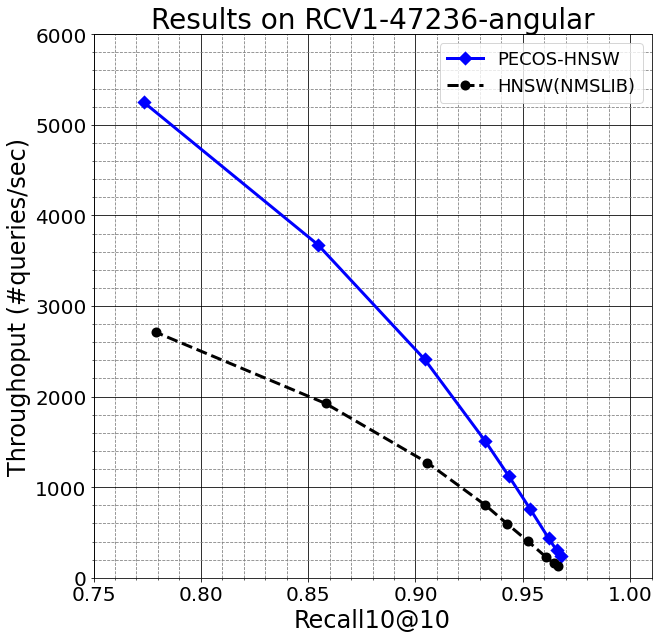

In [11]:
results_dict = get_results_rcv1()
plot_one(
    results_dict,
    xlim=0.75,
    ylim=6000,
    title="Results on RCV1-47236-angular",
)

### Plot SIFT-128-euclidean

In [12]:
def get_results_sift():
    results_dict = {
        "PECOS-HNSW$^{++}$ (onging work)": {
            "color": "red",
            "marker": "X",
            "linestyle": "-",
            "recall": [
                0.49571,
                0.68714,
                0.82385,
                0.91453,
                0.94811,
                0.97443,
                0.99149,
                0.59568,
                0.79981,
                0.91674,
                0.97189,
                0.98643,
                0.99524,
                0.99869,
                0.64926,
                0.85598,
                0.95698,
                0.99031,
                0.99637,
                0.99872,
                0.99925,
            ],
            "throughput": [
                65812.90,
                32797.30,
                24629.80,
                13685.60,
                 9375.55,
                 5805.03,
                 2917.94,
                53613.60,
                34283.30,
                15798.90,
                11082.60,
                 7682.11,
                 4690.11,
                 2398.27,
                46432.80,
                30219.90,
                17348.00,
                 9557.86,
                 6556.19,
                 4058.41,
                 2072.55,
            ],
        },
        "PECOS-HNSW": {
            "color": "blue",
            "marker": "D",
            "linestyle": "-",
            "recall": [
                0.5640,
                0.7130,
                0.8350,
                0.9187,
                0.9522,
                0.9765,
                0.9922,
                0.7096,
                0.8404,
                0.9281,
                0.9759,
                0.9882,
                0.9958,
                0.9987,
                0.8014,
                0.9083,
                0.9685,
                0.9918,
                0.9964,
                0.9985,
                0.9990,
            ],
            "throughput": [
                38457.696,
                23871.502,
                13948.193,
                 7802.484,
                 5451.538,
                 3436.597,
                 1810.481,
                25668.715,
                16076.992,
                 9331.247,
                 5168.389,
                 3611.553,
                 2284.600,
                 1218.401,
                17172.999,
                10774.329,
                 6191.127,
                 3414.756,
                 2394.785,
                 1527.418,
                  831.661,
            ],
        },
        "HNSW(HNSWLIB-v0.4)": {
            "color": "gray",
            "marker": "o",
            "linestyle": "--",
            "recall": [
                0.5610,
                0.7121,
                0.8340,
                0.9200,
                0.9525,
                0.9774,
                0.9926,
                0.7107,
                0.8397,
                0.9290,
                0.9763,
                0.9887,
                0.9961,
                0.9989,
                0.7997,
                0.9091,
                0.9693,
                0.9922,
                0.9967,
                0.9990,
                0.9992,
            ],
            "throughput": [
                29658.555,
                19267.245,
                11726.411,
                 6800.556,
                 4799.454,
                 3042.605,
                 1623.884,
                18731.696,
                12097.183,
                 7304.240,
                 4155.413,
                 2949.101,
                 1901.381,
                 1040.917,
                11694.866,
                 7513.240,
                 4482.334,
                 2546.814,
                 1815.963,
                 1182.672,
                  655.921,
            ],
        }
    }
    return results_dict

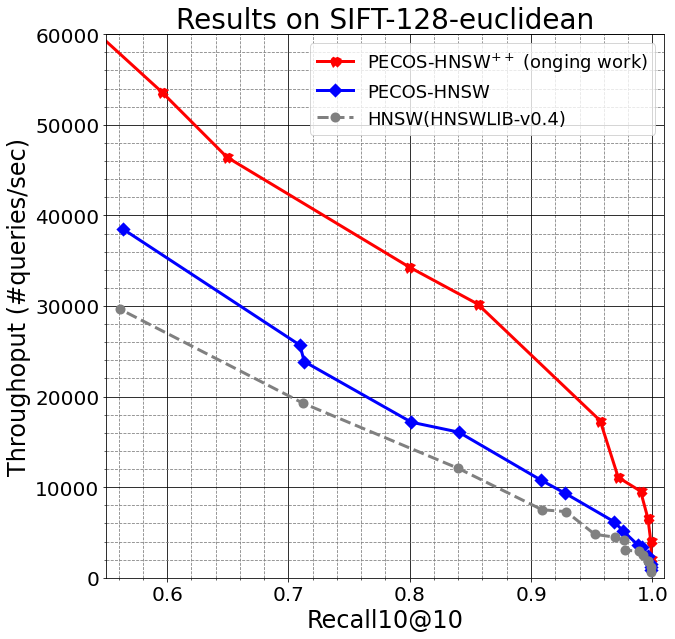

In [13]:
results_dict = get_results_sift()
plot_one(
    results_dict,
    xlim=0.55,
    ylim=60000,
    title="Results on SIFT-128-euclidean",
)

## Appendix: Install PECOS and NMSLIB

### Install via Conda 
```bash
conda create -n pecos-hnsw-tutorial python=3.8
conda activate pecos-hnsw-tutorial

pip install pyarrow pandas ipython jupyterlab
```

### Install PECOS from Source

We will install PECOS from source with the -march=native flag to optimize the best SIMD instruction available in your machine. More details available in https://github.com/amzn/pecos#installation-from-source

```bash
# prerequisite, assuming amazon linux 2 
sudo yum -y install python3 python3-devel python3-distutils python3-venv && sudo yum -y groupinstall 'Development Tools' 
sudo amazon-linux-extras install epel -y
sudo yum install openblas-devel -y
# pecos with -march=native flag
git clone https://github.com/amzn/pecos
cd pecos
PECOS_MANUAL_COMPILE_ARGS="-march=native" python -m pip install  --editable .
```

### Install NMSLIB from Source

We follow the install guide [install guide](https://github.com/erikbern/ann-benchmarks/blob/master/install/Dockerfile.nmslib) from ANN-Benchmark to install NMSLIB from source for the best performance.

```bash
# pre-requisite, assuming amazon linux 2
sudo yum -y install cmake boost-devel eigen3-devel
git clone https://github.com/searchivarius/nmslib.git
cd nmslib/similarity_search
cmake . -DWITH_EXTRAS=1
make -j4
pip install pybind11
cd ../python_bindings/
python setup.py build
python setup.py install
python -c 'import nmslib'
```

### Install via Docker (as in ANN-Benchmkark)

```bash
# install some basic stuff
sudo yum -y update
sudo yum install -y git curl zip unzip vim gcc-c++ htop

# https://docs.aws.amazon.com/AmazonECS/latest/developerguide/docker-basics.html
# sudo yum update -y
# sudo amazon-linux-extras install docker
sudo service docker start
sudo systemctl enable docker
sudo usermod -a -G docker ec2-user
docker info
```

### Install Docker Image

```bash
# install miniconda fist!
conda create -n ann-benchmarks python=3.8
conda activate ann-benchmarks

# install ANN package supported by ann-benchmarks
git clone https://github.com/erikbern/ann-benchmarks.git
cd ann-benchmarks
pip install -r requirements.txt

# install docker containers
python -u install.py --algorithm faiss
python -u install.py --algorithm hnswlib
python -u install.py --algorithm n2
python -u install.py --algorithm pecos
python -u install.py --algorithm scann
python -u install.py --algorithm ngt
python -u install.py --algorithm nmslib
python -u install.py --algorithm diskann
python -u install.py --algorithm pynndescent

# list all dockers
docker image ls
REPOSITORY TAG IMAGE ID CREATED SIZE
ann-benchmarks-hnswlib latest 2e1ea8d11df7 2 hours ago 1.04GB
ann-benchmarks-nmslib latest 1e094d3e96f7 3 hours ago 1.64GB
ann-benchmarks-faiss latest 44e5bd15bfcd 5 hours ago 4.9GB
ann-benchmarks-scann latest 5151abe3b09e 5 hours ago 2.76GB
ann-benchmarks latest c2c612131da4 5 hours ago 938MB
```

### Enter Docker Env

```bash
EFS_DIR=/PATH/TO/pecos-hnsw-kdd22
DOCKER_IMAGE=ann-benchmarks-nmslib

docker run --rm -it -v ${EFS_DIR}:/home/app/ws \
    --entrypoint /bin/bash ${DOCKER_IMAGE}
```